In [2]:
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, accuracy_score
import os
import csv
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# 2 roc curves for distance thresholds and 1 table with roc auc and fscore for parameters epidemicmodel and ml classifier

In [3]:
def extract_features(X):
    return np.array([[len(x), np.max(x), np.mean(x)] for x in X])

In [7]:

def human_human():
 pathlist=[]
 filelist=[]
 pr0='rss_smartphone-master/rss_smartphone-master'
 pr1= os.listdir(pr0)
 pr1.remove("_Figure")
 for x in pr1:
     filelist.append(os.listdir(pr0+'/'+x))
     pathlist.append(pr0+'/'+x)
  
 print(filelist)
 filelist=np.array([np.array(file) for file in filelist])
 traindata=[]
 for i in range(len(pathlist)):
     datasetfile=filelist[i][2]
     pathfile=pathlist[i]
     with open(pathfile+'/'+datasetfile, newline='') as f:
          reader = csv.reader(f)
          #traindata.append(list(reader))
          traindata=traindata+list(reader)[1:]
 
 traindata=np.array(traindata)
 ## human_human test data load
 testdata=[]
 for i in range(len(pathlist)):
     datasetfile=filelist[i][1]
     pathfile=pathlist[i]
     with open(pathfile+'/'+datasetfile, newline='') as f:
          reader = csv.reader(f)
          #testdata.append(list(reader))
          testdata=testdata+list(reader)[1:]
 testdata=np.array(testdata)
 X_train=traindata[:,2:5].astype('float')
 y_train=traindata[:,6].astype('float')
 
 X_test=testdata[:,2:5].astype('float')
 y_test=testdata[:,6].astype('float')
 return X_train, X_test, y_train, y_test

In [8]:
# nature dataset load

def nature_data():
 datasetpath="ble-proximity-tracing-master/data/bundeswehr-04-01/"
 data_train = json.load(open(datasetpath+"data_train.json", "r"))
 X_train = [d["rss"] for d in data_train]
 data_test = json.load( open(datasetpath+"data_test.json", "r"))
 X_test = [d["rss"] for d in data_test] # for nature
 traindist=[d["dist"] for d in data_train]
 testdist=[d["dist"] for d in data_test]
 cmthresh =  225 #225
 reflen=600
 return cmthresh,reflen,testdist,traindist,X_test,X_train

#y_train = [np.sum(epi_model(d["dist"]))>THRESHOLD for d in data_train]  # for nature
#y_test = [np.sum(epi_model(d["dist"]))>THRESHOLD for d in data_test]  # for nature

#y_train = [np.sum(epi_model(d))>THRESHOLD for d in traindist]  ## labels for human human data
#y_test = [np.sum(epi_model(d))>THRESHOLD for d in testdist] # for human human


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

epidemiologic_models = {
  "linear" : lambda x : 1/np.array(x),
  "box" : lambda x : np.array(x)<=cmthresh,
  "sigmoid" : lambda x : (1+np.exp((np.array(x)-cmthresh)/30))**(-1),
    "tanhyp":lambda x : np.tanh((np.array(x)-cmthresh)/30)
}
mlmodel_dict = {"logisticreg": LogisticRegression(max_iter=10000, tol=1e-10), "supportvec": svm.SVC(probability=True),
'lda':LinearDiscriminantAnalysis(), 'dtree':DecisionTreeClassifier(criterion="gini",max_depth=6) ,'knn':KNeighborsClassifier()}

dataset_load = {"nature": nature_data(), "human": human_human()}


In [9]:
X_train, X_test, y_train, y_test = dataset_load["human"]
print(X_train.shape, y_train.shape)
print(X_train)

(98975, 3) (98975,)
[[ -94.    -92.7   -86.81]
 [ -83.    -90.4   -86.82]
 [ -86.    -89.3   -86.92]
 ...
 [-102.   -102.2  -100.04]
 [ -99.   -100.9  -100.07]
 [-102.    -99.6  -100.04]]


Best Criterion: gini
Best max_depth: 6
[0.8, 0.84, 0.85, 0.85, 0.85, 0.85, 0.84, 0.71, 0.51]


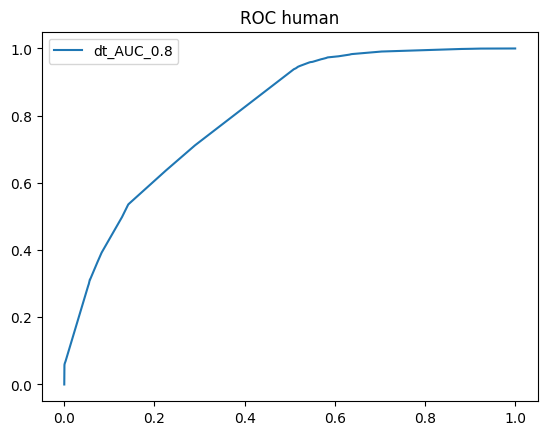

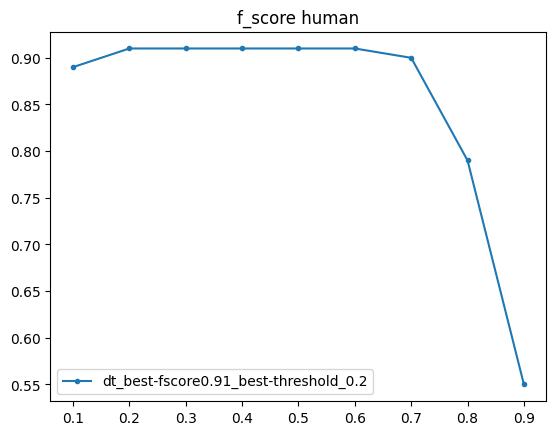

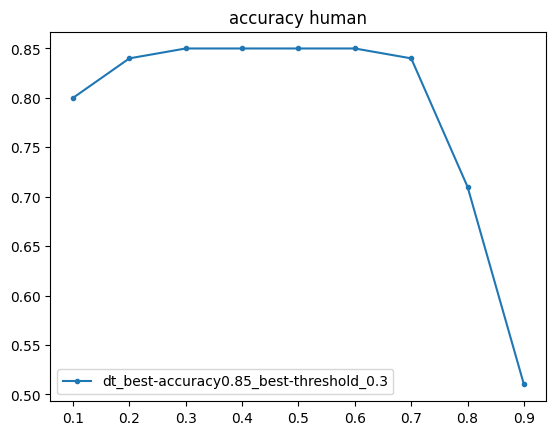

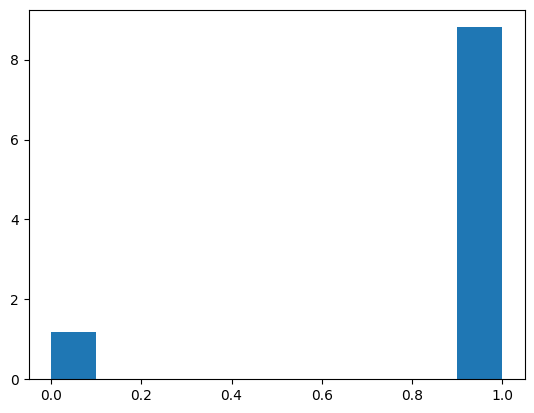

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12,20,40]
parameters = dict(
     criterion=criterion,
     max_depth=max_depth
)

dataset = "human"
ifig=3
ml_model = "dt"

model = DecisionTreeClassifier()
model = GridSearchCV(model, parameters)


y_train = [y>0 for y in y_train]  
y_test = [y>0 for y in y_test] 

model.fit(X_train, y_train)

print('Best Criterion:', model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', model.best_estimator_.get_params()['max_depth'])


y_test_pred_proba = model.predict_proba(X_test)
fpr, tpr, thresholds=roc_curve(y_test, y_test_pred_proba[:,1])
auc=str(round(roc_auc_score(y_test, y_test_pred_proba[:,1]),2))
plt.figure(1)
plt.plot(fpr,tpr,label=ml_model+'_AUC_'+auc)
plt.title('ROC '+dataset)
plt.legend()
plt.savefig('outputs/roc'+dataset)
#plt.show()
f1socres=[]
accuracies = []
CLASSIFIER_THRESHOLDS =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for CLASSIFIER_THRESHOLD in CLASSIFIER_THRESHOLDS:
 f1s=round(f1_score(y_test, y_test_pred_proba[:,1]>CLASSIFIER_THRESHOLD),2)
 acc = round(accuracy_score(y_test, y_test_pred_proba[:,1]>CLASSIFIER_THRESHOLD),2)
 f1socres.append(f1s)
 accuracies.append(acc)
plt.figure(2)
plt.plot(CLASSIFIER_THRESHOLDS,f1socres,marker='.',label=ml_model+'_best-fscore'+str(max(f1socres))+'_best-threshold_'+str(CLASSIFIER_THRESHOLDS[f1socres.index(max(f1socres))]))
plt.legend()
plt.title('f_score '+dataset)
plt.savefig('outputs/fscore'+dataset)
plt.figure(3)
plt.plot(CLASSIFIER_THRESHOLDS,accuracies,marker='.',label=ml_model+'_best-accuracy'+str(max(accuracies))+'_best-threshold_'+str(CLASSIFIER_THRESHOLDS[accuracies.index(max(accuracies))]))
plt.legend()
plt.title('accuracy '+dataset)
plt.savefig('outputs/accuracy'+dataset)

plt.figure(3+ifig)
plt.hist(np.argmax(y_test_pred_proba,axis=1), density=True)

print(accuracies)
plt.show()

[0.82, 0.84, 0.84, 0.84, 0.84, 0.79, 0.79, 0.65, 0.65]


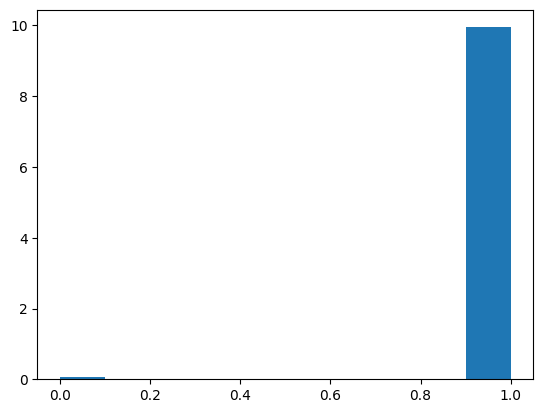

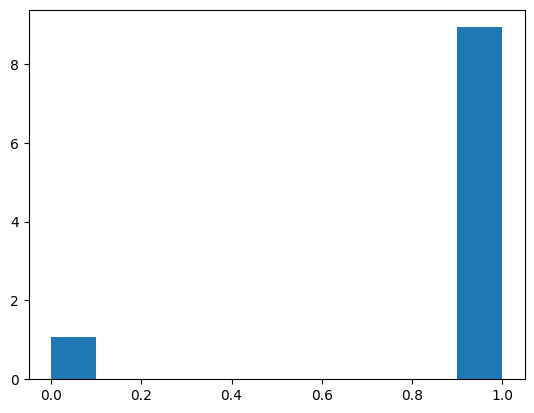

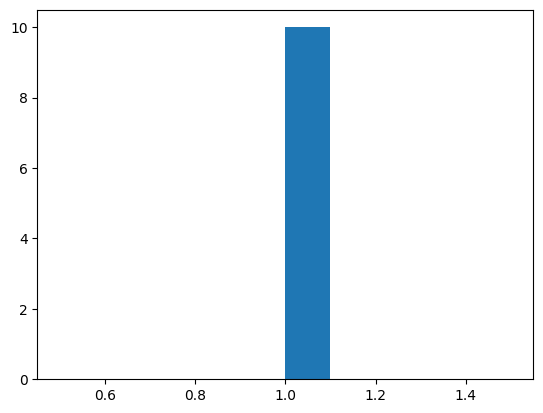

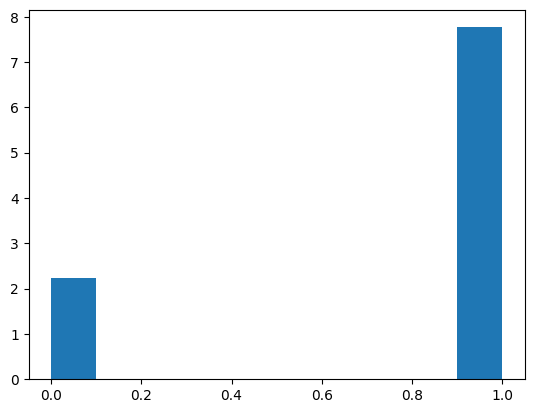

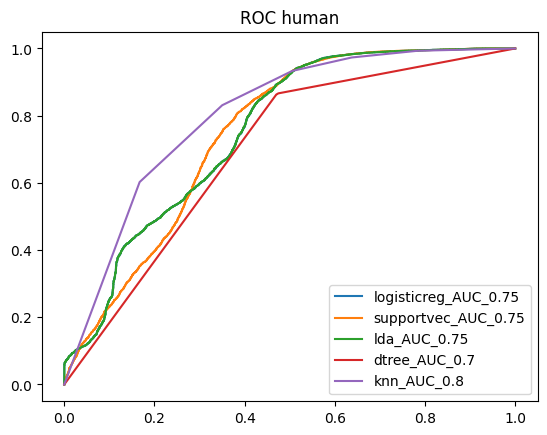

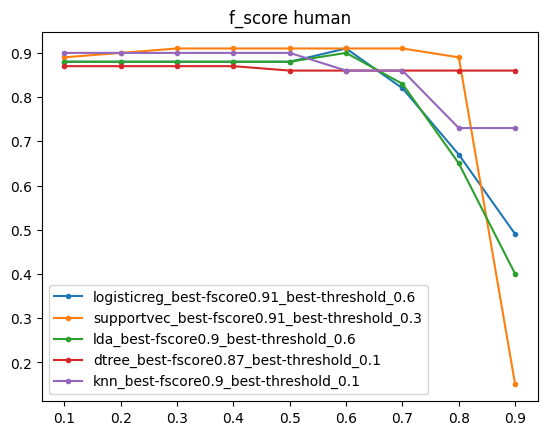

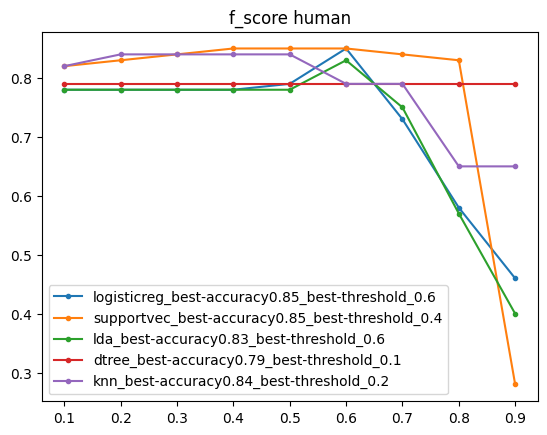

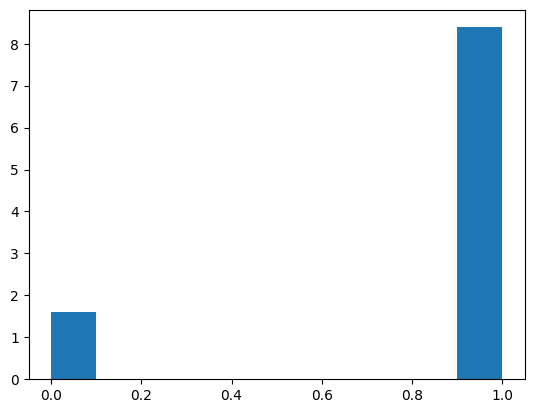

In [10]:
dataset = "human"
ifig=3
for ml_model in ["logisticreg" , "supportvec",'lda', 'dtree' ,'knn']:
   model=mlmodel_dict[ml_model]
   y_train = [y>0 for y in y_train] 
   y_test = [y>0 for y in y_test] 
   model.fit(X_train, y_train)
   y_test_pred_proba = model.predict_proba(X_test)
   fpr, tpr, thresholds=roc_curve(y_test, y_test_pred_proba[:,1])
   auc=str(round(roc_auc_score(y_test, y_test_pred_proba[:,1]),2))
   plt.figure(1)
   plt.plot(fpr,tpr,label=ml_model+'_AUC_'+auc)
   plt.title('ROC '+dataset)
   plt.legend()
   plt.savefig('outputs/roc'+dataset)
   #plt.show()
   f1socres=[]
   accuracies = []
   CLASSIFIER_THRESHOLDS =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
   for CLASSIFIER_THRESHOLD in CLASSIFIER_THRESHOLDS:
    f1s=round(f1_score(y_test, y_test_pred_proba[:,1]>CLASSIFIER_THRESHOLD),2)
    acc = round(accuracy_score(y_test, y_test_pred_proba[:,1]>CLASSIFIER_THRESHOLD),2)
    f1socres.append(f1s)
    accuracies.append(acc)
   plt.figure(2)
   plt.plot(CLASSIFIER_THRESHOLDS,f1socres,marker='.',label=ml_model+'_best-fscore'+str(max(f1socres))+'_best-threshold_'+str(CLASSIFIER_THRESHOLDS[f1socres.index(max(f1socres))]))
   plt.legend()
   plt.title('f_score '+dataset)
   plt.savefig('outputs/fscore'+dataset)

   plt.figure(3)
   plt.plot(CLASSIFIER_THRESHOLDS,accuracies,marker='.',label=ml_model+'_best-accuracy'+str(max(accuracies))+'_best-threshold_'+str(CLASSIFIER_THRESHOLDS[accuracies.index(max(accuracies))]))
   plt.legend()
   plt.title('accuracy '+dataset)
   plt.savefig('outputs/accuracy'+dataset)
   

   plt.figure(3+ifig)
   plt.hist(np.argmax(y_test_pred_proba,axis=1), density=True)
   #plt.savefig('f:/junaid/prdpdf'+str(cmthresh)+str(ifig))
   ifig=ifig+1
print(accuracies)
plt.show()

# Compute the number Positives, True Positives, Negatives and False Positives

TP = np.sum(y_test _ (y_test_pred_proba[:,1]>CLASSIFIER_THRESHOLD))
P = np.sum(y_test)
FP = np.sum((1-np.array(y_test)) _ (y_test_pred_proba[:,1]>CLASSIFIER_THRESHOLD))
N = np.sum((1-np.array(y_test)) )
#print('classifier_thresh',CLASSIFIER_THRESHOLD)
#print("Positive {}\nTrue Positive {}\nNegative {}\nFalse Positive {}".format(P, TP, N, FP))

# neural net

outdata=to_categorical(outdata1)
werlabelval=to_categorical(werlabelval1)
spl=len(indata)
inputdim=len(indata[0])
outputdim=len(outdata[0])
input_flat1 = Input(shape=(inputdim,))
hidden_layer1 = Dense(int((outputdim+inputdim)/2))(input_flat1)
h2=BatchNormalization()(hidden_layer1)
h3=PReLU()(h2)
h4=Dropout(0.1)(h3)
output_layer1 = Dense(outputdim, activation='softmax')(h4)
emodel1 = Model(input_flat1,output_layer1)
emodel1.compile(optimizer='Nadam', loss='categorical_crossentropy')
emodel1.summary()
#plot_model(emodel1, to_file='dmodel.png')
es = EarlyStopping(monitor='val_loss', mode='min',verbose=1, patience=dpt)
hist= emodel1.fit(indata,outdata,epochs=epc,batch_size=32,shuffle=True,validation_split=dvspt,callbacks=[es])
flat_outa = emodel1.predict(werval)
